# Análise do Data Warehouse - (Cursos Superior, Faixa Etária, Brasil)

Análise dos dados disponibilizados no Data Warehouse



**Instalando o Cassandra no Jupyter**

`docker-compose exec jupyter pip install cassandra-driver`

## Imports

In [1]:
#Imports
from time import sleep

In [2]:
#Imports Cassandra
from cassandra.auth import PlainTextAuthProvider
from cassandra.cluster import Cluster

In [3]:
#Imports Pandas
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

## Conexão ao banco de Dados Cassandra

In [4]:
#Conectando a seção
ap = PlainTextAuthProvider(username='cassandra', password='cassandra')
cluster = Cluster(['cassandra'], protocol_version=4, auth_provider=ap)
session = cluster.connect('alunos')
session.default_timeout = 60
session.row_factory = pandas_factory
sleep(2)

## Consulta

In [5]:
table = 'fato_aluno_etaria'
field = 'faixa_etaria'
curse_types = ['Bacharelado','Licenciatura','Tecnologia']
filters = {    
    'categoria_situacao': ['Evadidos','Concluintes'],
    'unidade_ensino': '',
    'instituicao': '',
}

In [6]:
s = []
for k, v in filters.items():
    if v :
        if type(v) is str:
            s.append("({} = '{}')".format(k,v))
        elif type(v) is list:
            s.append("({} IN ({}))".format(
                k,
                ','.join(map(str,["'{}'".format(i) for i in v]))))
filter_sql = " AND ".join(map(str,s))

In [7]:
# Análise de Sexo
sql = "SELECT categoria_situacao, {0}, tipo_curso, instituicao, unidade_ensino, sum(quant_grupo) AS quant_grupo" \
" FROM {1} " \
" WHERE {2} " \
" GROUP BY categoria_situacao, {0}, tipo_curso, instituicao " \
" ALLOW FILTERING;".format(
    field, 
    table,
    filter_sql)
rslt = session.execute(sql, timeout=None)
df = rslt._current_rows
df

,categoria_situacao,faixa_etaria,tipo_curso,instituicao,unidade_ensino,quant_grupo
0,Concluintes,15 a 19 anos,Bacharelado,CEFET-RJ,Unidade Maracanã,1
1,Concluintes,15 a 19 anos,Bacharelado,IFRO,Campus Colorado do Oeste,1
2,Concluintes,15 a 19 anos,Ensino Fundamental I,CPII,Campus Engenho Novo I,4
3,Concluintes,15 a 19 anos,Ensino Fundamental II,CPII,Campus Centro,1740
4,Concluintes,15 a 19 anos,Ensino Médio,CPII,Campus Centro,1301
...,...,...,...,...,...,...
4995,Evadidos,50 a 54 anos,Técnico,UFMG - COLTEC,Colégio Técnico da UFMG,1
4996,Evadidos,50 a 54 anos,Técnico,UFPB - ETS,Escola Técnica de Saúde da UFPB,11
4997,Evadidos,50 a 54 anos,Técnico,UFPI - CAT,Colégio Técnico de Teresina da UFPI,2
4998,Evadidos,50 a 54 anos,Técnico,UFRN - EAJ,Escola Agrícola de Jundiaí da UFRN,49


## Filtrando Tipo do Curso

In [8]:
if curse_types :
    df = df[df['tipo_curso'].isin(curse_types)]
    print('Fitrando pelos tipos de cursos:\n {}'.format(', '.join(map(str,curse_types))))
    
else:
    print('Todos os cursos')
df

Fitrando pelos tipos de cursos:
 Bacharelado, Licenciatura, Tecnologia


,categoria_situacao,faixa_etaria,tipo_curso,instituicao,unidade_ensino,quant_grupo
0,Concluintes,15 a 19 anos,Bacharelado,CEFET-RJ,Unidade Maracanã,1
1,Concluintes,15 a 19 anos,Bacharelado,IFRO,Campus Colorado do Oeste,1
14,Concluintes,15 a 19 anos,Licenciatura,IFCE,Campus Maranguape,1
15,Concluintes,15 a 19 anos,Licenciatura,IFES,Campus Cariacica,2
16,Concluintes,15 a 19 anos,Licenciatura,IFSP,Campus Guarulhos,1
...,...,...,...,...,...,...
4946,Evadidos,50 a 54 anos,Tecnologia,IFSULDEMINAS,Campus Passos,2
4947,Evadidos,50 a 54 anos,Tecnologia,IFTM,Campus Uberaba,7
4948,Evadidos,50 a 54 anos,Tecnologia,IFTO,Campus Palmas,9
4949,Evadidos,50 a 54 anos,Tecnologia,UFSM - POLITECNICO,Colégio Politécnico da UFSM,1


## Agrupando

In [9]:
df = df.groupby(['categoria_situacao',field]).sum('quant_grupo').reset_index()

<AxesSubplot:xlabel='faixa_etaria'>

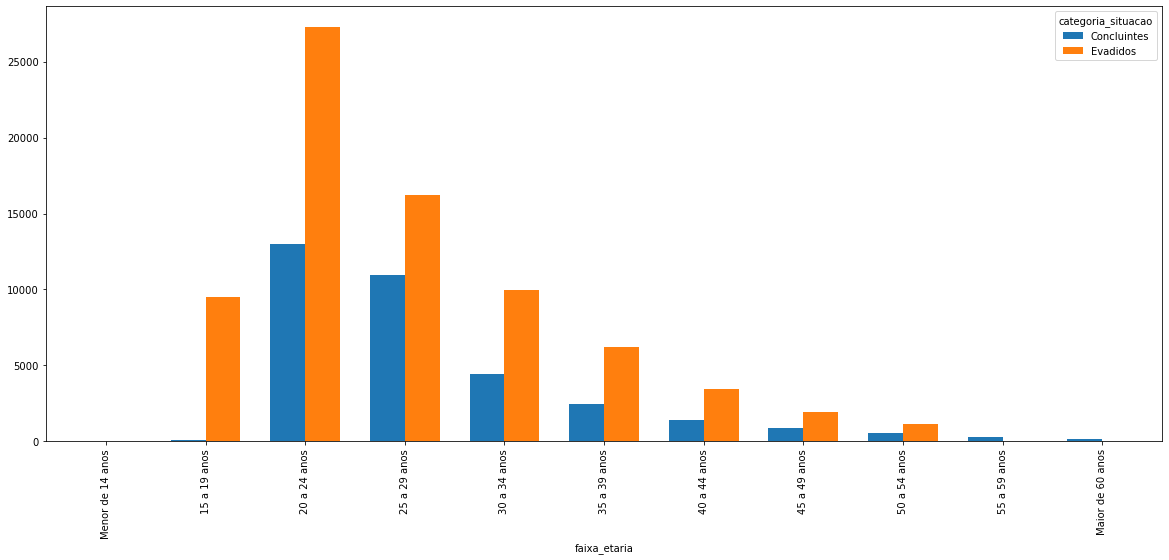

In [17]:
x = df.pivot_table('quant_grupo',[field],'categoria_situacao')
#x = df.pivot_table('quant_grupo',['categoria_situacao'],field)
order = [
    'Menor de 14 anos', '15 a 19 anos','20 a 24 anos',
    '25 a 29 anos','30 a 34 anos','35 a 39 anos',
    '40 a 44 anos','45 a 49 anos', '50 a 54 anos','55 a 59 anos',
    'Maior de 60 anos']
x.reindex(order).plot(kind ='bar', figsize=(20, 8), width = 0.7)

## Total de Alunos

In [19]:
#df[field]
df.groupby([field]).sum('quant_grupo')['quant_grupo'].reindex(order)

faixa_etaria
Menor de 14 anos        1
15 a 19 anos         9584
20 a 24 anos        40285
25 a 29 anos        27180
30 a 34 anos        14396
35 a 39 anos         8691
40 a 44 anos         4870
45 a 49 anos         2761
50 a 54 anos         1631
55 a 59 anos          300
Maior de 60 anos      154
Name: quant_grupo, dtype: int64

In [28]:
#df[field]
df.groupby(['categoria_situacao', field]).sum('quant_grupo')['quant_grupo']

categoria_situacao  faixa_etaria    
Concluintes         15 a 19 anos           65
                    20 a 24 anos        13008
                    25 a 29 anos        10964
                    30 a 34 anos         4429
                    35 a 39 anos         2468
                    40 a 44 anos         1422
                    45 a 49 anos          859
                    50 a 54 anos          520
                    55 a 59 anos          300
                    Maior de 60 anos      154
                    Menor de 14 anos        1
Evadidos            15 a 19 anos         9519
                    20 a 24 anos        27277
                    25 a 29 anos        16216
                    30 a 34 anos         9967
                    35 a 39 anos         6223
                    40 a 44 anos         3448
                    45 a 49 anos         1902
                    50 a 54 anos         1111
Name: quant_grupo, dtype: int64

In [12]:
print("Total de aluns: {:,}".format(df['quant_grupo'].sum()).replace(',','.'))

Total de aluns: 109.853
